### Classification based on point cloud features

In [1]:
import cv2
import numpy as np
import pandas as pd
import pickle
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
#%matplotlib inline
%pylab inline
import os
import sys
from time import time
from glob import glob
sys.path.append(os.environ['REPO_DIR'])
from extractPatches import patch_extractor
from lib.utils import configuration

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Parameters
param = {}
param['max_depth']= 3   # depth of tree
param['eta'] = 0.2      # shrinkage parameter
param['silent'] = 1     # not silent
param['objective'] = 'binary:logistic' #'multi:softmax'
param['nthread'] = 7 # Number of threads used
param['num_class']=1

In [3]:
def get_scores(X_train, X_valid, y_train, param, num_round):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_valid)
    bst = xgb.train(param, dtrain, num_round, verbose_eval=False)
    score = bst.predict(dval, output_margin=True, ntree_limit=bst.best_ntree_limit)
    score = np.around(score, 3)
    
    return score

In [26]:
from sklearn import metrics
def buildROC(target_test,test_preds, num_round,structure):
    fpr, tpr, threshold = metrics.roc_curve(target_test, test_preds)
    roc_auc = metrics.auc(fpr, tpr)
    #plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, label=str(num_round))#, 'b', label = 'AUC = %0.2f' % roc_auc)
    #plt.legend(loc = 'lower right')
    loc = np.random.choice(range(len(fpr)),1)[0]
    plt.text(fpr[loc],tpr[loc],structure)
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    return roc_auc

In [9]:
paired_structures = ['5N', '6N', '7nn', '7N', 'Amb', 'LC', 'LRt', 'Pn', 'Tz', 'VLL', 'RMC', \
                     'SNC', 'SNR', '3N', '4N', 'Sp5I', 'Sp5O', 'Sp5C', 'PBG', '10N', 'VCA', 'VCP', 'DC']
singular_structures = ['AP', '12N', 'RtTg', 'SC', 'IC']

all_structures = paired_structures + singular_structures

In [6]:
stack = 'MD594'
feature_dir = os.environ['ROOT_DIR'] + 'CSHL_patches_features/'+stack+'/'
cell_dir = os.environ['ROOT_DIR'] + 'CSHL_patches_features/MD589/'


In [13]:
!mkdir figures
fn = 'figures/'

mkdir: figures: File exists


5N 480 479 0.799791449426486
6N 269 216 0.7711340206185567
7nn 1000 1000 0.8885
7N 830 826 0.822463768115942
Amb 120 120 0.8625
LC 240 240 0.7729166666666667
LRt 719 720 0.7720639332870048
Pn 938 921 0.7907477138246369
Tz 440 437 0.8688711516533637
VLL 650 650 0.786923076923077
RMC 500 500 0.845
SNC 940 883 0.7652221612726275
SNR 1000 1000 0.711
3N 230 230 0.85
4N 140 113 0.9090909090909091
Sp5I 709 710 0.780831571529246
Sp5O 680 680 0.7095588235294118
Sp5C 999 1000 0.6778389194597298
PBG 250 233 0.7639751552795031
10N 330 271 0.800332778702163
VCA 660 638 0.8389830508474576
VCP 450 416 0.8117782909930716
DC 850 811 0.7928958458759783
AP 190 190 0.8710526315789474
12N 390 390 0.8666666666666667
RtTg 800 800 0.720625
SC 1000 1000 0.643
IC 1000 1000 0.7695


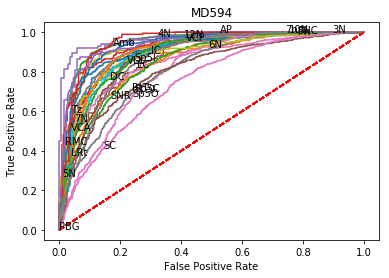

In [37]:
acc_all=[]
num_round=np.array([100])
auc_all = np.zeros((len(num_round), len(all_structures)))
#plt.figure(figsize=[15,50])
plt.figure()
for structure in all_structures:
    seq = np.where(np.array(all_structures)==structure)[0]
    #plt.subplot(10,3,seq+1)
    #plt.figure()
    fp =[]
    fp.append(cell_dir+structure+'/MD589_'+structure+'_positive.pkl') 
    fp.append(cell_dir+structure+'/MD589_'+structure+'_negative.pkl') 
    X_train = []
    y_train = []
    for state in range(2):
        clouds = pickle.load(open(fp[state],'rb'))
        X_train.extend(np.array(clouds))
        y_train.extend([1-state]*len(clouds))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    fp =[]
    fp.append(feature_dir+structure+'/'+stack+'_'+structure+'_positive.pkl') 
    fp.append(feature_dir+structure+'/'+stack+'_'+structure+'_negative.pkl')
    X_valid = []
    y_valid = []
    for state in range(2):
        clouds = pickle.load(open(fp[state],'rb'))
        X_valid.extend(np.array(clouds))
        y_valid.extend([1-state]*len(clouds))
    X_valid = np.array(X_valid)
    y_valid = np.array(y_valid)
    
    for i in range(len(num_round)):
        y_pred_valid = get_scores(X_train, X_valid, y_train, param, num_round[i])
        pred = y_pred_valid>0
        acc = sum(pred ==y_valid)/len(y_valid)
        auc = buildROC(y_valid, y_pred_valid, num_round[i],structure)
        auc_all[i,seq] = auc
    #plt.title(structure+' AUC = %0.2f'%auc)
    acc_all.append(acc)
    print(structure, len(y_valid)-sum(y_valid), sum(y_valid), acc)
    #plt.savefig(fn+stack+'_'+structure+'_ROC.jpg')
plt.title(stack)
plt.savefig(fn+stack+'_ROC.jpg')

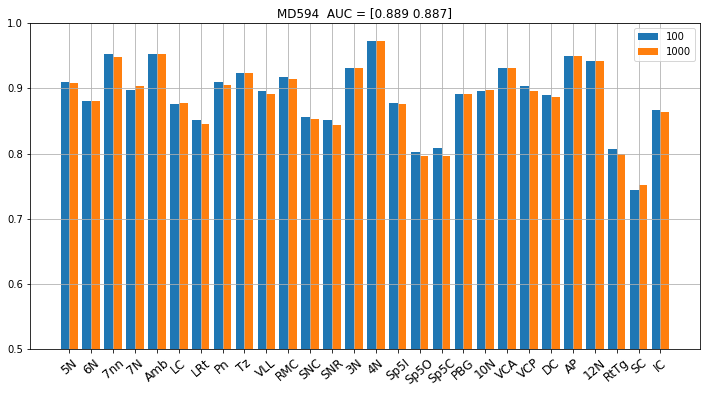

In [14]:
figure(figsize=(12,6))
index = np.arange(auc_all.shape[1])
width = 0.4
for i in range(len(num_round)):
    plt.bar(index+i*width, auc_all[i,:], width, label=str(num_round[i]))
plt.xticks(rotation=40)
plt.xticks(fontsize=12)
plt.xticks(index+width/2, all_structures)
plt.grid(True)
plt.ylim(0.5,1)
plt.legend()
plt.title(stack+'  AUC = '+str(np.round(np.mean(auc_all,1),3)))
plt.savefig(fn+stack+'_AUC.jpg')

5N 440 440 0.821969696969697
6N 43 50 0.8928571428571429
7nn 1000 1000 0.92
7N 890 884 0.8761726078799249
Amb 130 130 0.9102564102564102
LC 240 240 0.9166666666666666
LRt 760 760 0.8552631578947368
Pn 992 1000 0.8729096989966555
Tz 500 500 0.8633333333333333
VLL 690 690 0.8454106280193237
RMC 570 570 0.8742690058479532
SNC 785 830 0.8536082474226804
SNR 1000 999 0.7866666666666666
3N 240 240 0.9097222222222222
4N 120 45 0.94
Sp5I 730 730 0.8333333333333334
Sp5O 662 680 0.7568238213399504
Sp5C 1000 1000 0.7583333333333333
PBG 216 260 0.8881118881118881
10N 460 405 0.9038461538461539
VCA 660 647 0.905852417302799
VCP 489 475 0.8827586206896552
DC 1000 996 0.8864774624373957
AP 145 150 0.9213483146067416
12N 390 389 0.8589743589743589
RtTg 150 150 0.8666666666666667
SC 1000 1000 0.7
IC 999 1000 0.85


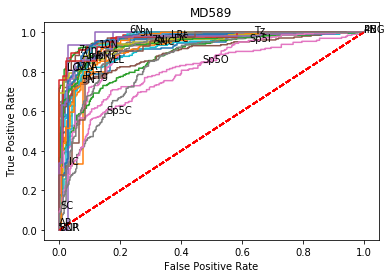

In [36]:
acc_all=[]
num_round=np.array([100])
auc_all = np.zeros((len(num_round), len(all_structures)))
plt.figure() #figsize=[15,50]
for structure in all_structures:
    seq = np.where(np.array(all_structures)==structure)[0]
    #plt.subplot(10,3,seq+1)
    fp =[dir for dir in glob(cell_dir+structure+'/*')]
    features = []
    labels = []
    for state in range(2):
        clouds = pickle.load(open(fp[state],'rb'))
        features.extend(np.array(clouds))
        labels.extend([1-state]*len(clouds))
    features = np.array(features)
    labels = np.array(labels)
    X_train, X_valid, y_train, y_valid = train_test_split(features, labels, test_size=0.30, random_state=6)
    for i in range(len(num_round)):
        y_pred_valid = get_scores(X_train, X_valid, y_train, param, num_round[i])
        pred = y_pred_valid>0
        acc = sum(pred ==y_valid)/len(y_valid)
        auc = buildROC(y_valid, y_pred_valid, num_round[i],structure)
        auc_all[i,seq] = auc
    #plt.title(structure+' AUC = %0.2f'%auc)
    acc_all.append(acc)
    print(structure, len(labels)-sum(labels), sum(labels), acc)
plt.title('MD589')
plt.savefig(fn+'MD589_ROC.jpg')

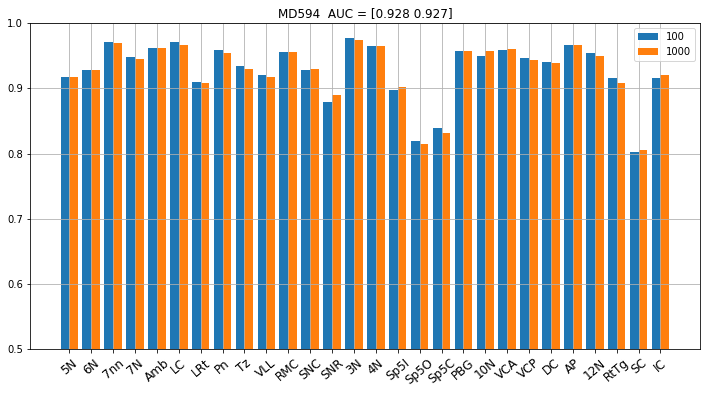

In [17]:
figure(figsize=(12,6))
index = np.arange(auc_all.shape[1])
width = 0.4
for i in range(len(num_round)):
    plt.bar(index+i*width, auc_all[i,:], width, label=str(num_round[i]))
plt.xticks(rotation=40)
plt.xticks(fontsize=12)
plt.xticks(index+width/2, all_structures)
plt.grid(True)
plt.ylim(0.5,1)
plt.legend()
plt.title(stack+'  AUC = '+str(np.round(np.mean(auc_all,1),3)))
plt.savefig(fn+'MD589_AUC.jpg')

In [30]:
!aws s3 ls s3://mousebrainatlas-data/CSHL_data_processed/MD585/

                           PRE MD585_custom_transforms/
                           PRE MD585_elastix_output/
                           PRE MD585_masks/
                           PRE MD585_masks_alignedTo_MD585-N47-2015.07.16-22.50.52_MD585_3_0141/
                           PRE MD585_masks_alignedTo_MD585-N47-2015.07.16-22.50.52_MD585_3_0141_cropped/
                           PRE MD585_prep1_thumbnail/
                           PRE MD585_prep1_thumbnail_mask/
                           PRE MD585_prep2_down8_grayJpeg/
                           PRE MD585_prep2_lossless/
                           PRE MD585_prep2_lossless_gray/
                           PRE MD585_prep2_lossless_jpeg/
                           PRE MD585_prep2_thumbnail/
                           PRE MD585_prep3_lossless/
                           PRE MD585_prep3_lossless_jpeg/
                           PRE MD585_prep3_thumbnail/
                           PRE MD585_prep5_thumbnail/
                           PRE 

In [7]:
origin= ['area', 'height', 'horiz_std', 'mean', 'padded_size',
       'rotation', 'rotation_confidence', 'std', 'vert_std', 'width', 'density']
columns = []
for i in range(10):
    name = 'DMVec'+str(i)
    for j in range(10):
        columns.append(name+'*'+str(np.around(0.1*(j+1),2)))
for i in range(10):
    name = origin[i]
    for j in range(10):
        columns.append(name+'*'+str(np.around(0.1*(j+1),2)))
columns.append(origin[-1])

In [8]:
sets = columns
! mkdir FeatureMap

mkdir: FeatureMap: File exists


LC 479 0.875


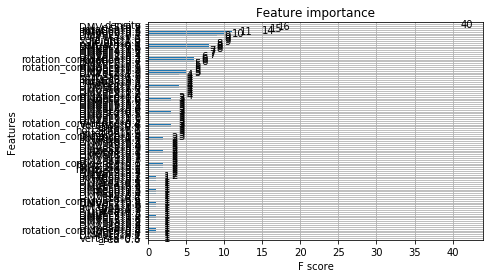

In [13]:
structure = 'LC'
fp =[dir for dir in glob(cell_dir+structure+'/*')]
features = []
labels = []
for state in range(2):
    clouds = pickle.load(open(fp[state],'rb'))
    features.extend(np.array(clouds))
    labels.extend([state]*len(clouds))
features = np.array(features)
labels = np.array(labels)
data = pd.DataFrame(features,columns=sets)
label = pd.DataFrame(labels)
X_train, X_valid, y_train, y_valid = train_test_split(data, label, test_size=0.30, random_state=6)
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_valid)
num_round = 100
bst = xgb.train(param, dtrain, num_round, verbose_eval=False)
score = bst.predict(dval, output_margin=True, ntree_limit=bst.best_ntree_limit)
y_pred_valid = np.around(score, 3)
pred = y_pred_valid>0
acc = sum(pred.reshape(-1,1) == np.array(y_valid))/len(y_valid)
print(structure, features.shape[0], acc)
xgb.plot_importance(bst)
# plt.savefig('FeatureMap/'+structure+'.jpg')
# fig = plt.figure(figsize=(18,18))
# iax = fig.add_subplot(111)
# xgb.plot_tree(bst,ax=iax)
# plt.savefig('FeatureMap/'+structure+'_tree.jpg')

In [13]:
cell_dir = os.environ['ROOT_DIR'] + 'CSHL_new_regions_features/MD589/'

In [14]:
for structure in all_structures:
    #structure = '12N'
    fp =[dir for dir in glob(cell_dir+structure+'/*')]
    features = []
    labels = []
    for state in range(2):
        clouds = pickle.load(open(fp[state],'rb'))
        features.extend(np.array(clouds))
        labels.extend([state]*len(clouds))
    features = np.array(features)
    labels = np.array(labels)
    X_train, X_valid, y_train, y_valid = train_test_split(features, labels, test_size=0.30, random_state=6)
    y_pred_valid = get_scores(X_train, X_valid, y_train, param)
    pred = y_pred_valid>0
    #pred = get_predictions(y_pred_valid)
    acc = sum(pred ==y_valid)/len(y_valid)
    print(structure, features.shape[0], acc)

5N 88 1.0
6N 10 0.3333333333333333
7N 178 1.0
7n 252 0.9868421052631579
Amb 26 0.875
LC 48 0.9333333333333333
LRt 152 0.9782608695652174
Pn 202 0.9836065573770492
Tz 100 0.9666666666666667
VLL 138 1.0
RMC 114 0.8857142857142857
SNC 166 1.0
SNR 252 0.9736842105263158
3N 48 0.9333333333333333
4N 24 1.0
Sp5I 146 0.9545454545454546
Sp5O 136 0.975609756097561
Sp5C 282 1.0
PBG 52 0.8125
10N 92 0.9285714285714286
VCA 132 1.0
VCP 98 0.9666666666666667
DC 222 0.9402985074626866
AP 30 0.7777777777777778
12N 78 1.0
RtTg 30 0.7777777777777778
SC 364 1.0
IC 382 0.991304347826087
